In [476]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
import math
import random
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [478]:
def get_hurst_exponent(time_series, max_lag=20):
        lags = range(2, max_lag)

        # variances of the lagged differences
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

        # calculate the slope of the log plot -> the Hurst Exponent
        reg = np.polyfit(np.log(lags), np.log(tau), 1)

        return reg[0]

In [477]:
start_data='2010-01-04'
end_data='2023-01-13'

lst=['GIS']

In [1023]:
wheat=yf.download('ZW=F', start=start_data, end=end_data).dropna()
wheat['logret']=np.log(wheat['Adj Close'])-np.log(wheat['Adj Close'])
wheat.index = pd.to_datetime(wheat.index)
wheat = wheat.reindex(pd.date_range(wheat.index.min(), wheat.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
wheat=wheat.interpolate(method='bfill',order=3)

import warnings
warnings.filterwarnings('ignore')

pairs_df=pd.DataFrame()
coint_pairs=[]
for i in range(0,len(lst)):
    Asset1 = yf.download(lst[i], start=start_data, end='2023-01-14')
    Asset1['logret']=np.log(Asset1['Adj Close'])-np.log(Asset1['Adj Close'].shift(1))
    Asset1.index = pd.to_datetime(Asset1.index)
    Asset1 = Asset1.reindex(pd.date_range(Asset1.index.min(), Asset1.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    Asset1=Asset1.interpolate(method='bfill',order=2)

    score, pvalue, _ = coint(wti['logret'],Asset1['logret'])
    confidence_level = 0.05
    if pvalue < confidence_level:
        coint_pairs.append(('Wheat',lst[i]))
        pairs_df['spread'] = np.abs(wheat['logret'] - Asset1['logret'])
        hurst_exp = get_hurst_exponent(pairs_df['spread'].values)
        print(lst[i],'Hurst Expo',hurst_exp)

   

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GIS Hurst Expo 0.04723272851528844


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


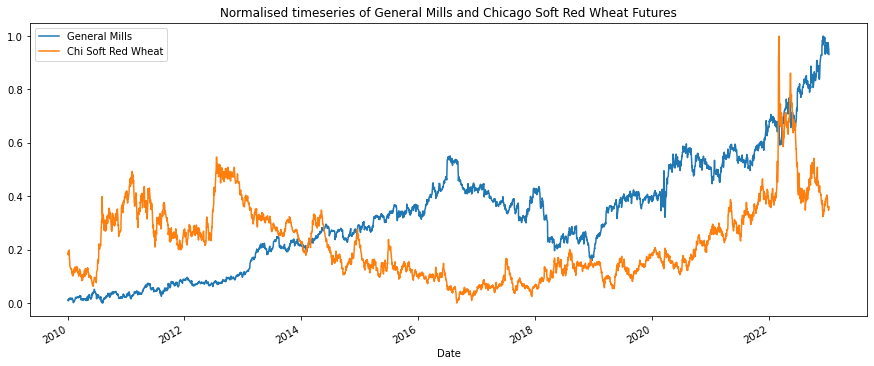

In [683]:
Asset1 = yf.download('GIS', start=start_data, end=end_data)
Asset1['Adj Close Norm']=(Asset1['Adj Close']-Asset1['Adj Close'].min())/(Asset1['Adj Close'].max()-Asset1['Adj Close'].min())
Asset1['Adj Close Norm'].plot(figsize=(15,6),label='General Mills')
Asset2 = yf.download('ZW=F', start=start_data, end=end_data)
Asset2['Adj Close Norm']=(Asset2['Adj Close']-Asset2['Adj Close'].min())/(Asset2['Adj Close'].max()-Asset2['Adj Close'].min())
Asset2['Adj Close Norm'].plot(figsize=(15,6),label='Chi Soft Red Wheat')
plt.title("Normalised timeseries of General Mills and Chicago Soft Red Wheat Futures")
plt.legend()
plt.show()

In [491]:
spread=np.abs(Asset1['Adj Close']-Asset2['Adj Close'])
dates = pd.date_range(start_data,end_data,freq='D')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df.head()

,Adj Close
2010-01-04,534.773445
2010-01-05,530.237328
2010-01-06,544.351221
2010-01-07,534.482466
2010-01-08,545.421740


In [492]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm

,Adj Close
2010-01-04,-0.563445
2010-01-05,-0.572045
2010-01-06,-0.545287
2010-01-07,-0.563997
2010-01-08,-0.543257
...,...
2023-01-09,-0.332060
2023-01-10,-0.350773
2023-01-11,-0.333520
2023-01-12,-0.325614


In [818]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.15*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.25*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [985]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3032, 1, 1)
y_train.shape =  (3032, 1)
x_val.shape =  (1011, 1, 1)
y_val.shape =  (1011, 1)
x_test.shape =  (713, 1, 1)
y_test.shape =  (713, 1)


In [986]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [987]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size()

(torch.Size([3032, 1]),
 torch.Size([3032, 1, 1]),
 torch.Size([1011, 1]),
 torch.Size([1011, 1, 1]),
 torch.Size([713, 1]),
 torch.Size([713, 1, 1]))

In [988]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,stateful):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

In [989]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,stateful=True)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [990]:
num_epochs =1000
mse_train=[]
mse_val=[]
hist = np.zeros(num_epochs)
seq_dim =look_back-1  
for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass 

    loss_train = loss(y_train_prediction, y_train)
    mse_train.append(loss_train.item())
    if t % 1000 == 0 and t !=0:
        print("Epoch", t, "Train MSE: ", loss_train.item())
    
    hist[t] = loss_train.item()
    optimiser.zero_grad()
    loss_train.backward() #backward pass
    optimiser.step() #update parameters
    
    y_val_prediction=model(x_val)
    loss_val = loss(y_val_prediction, y_val)
    mse_val.append(loss_val.item())
    if t % 1000 == 0 and t !=0:
        print("Epoch", t, " Val MSE: ", loss_val.item())

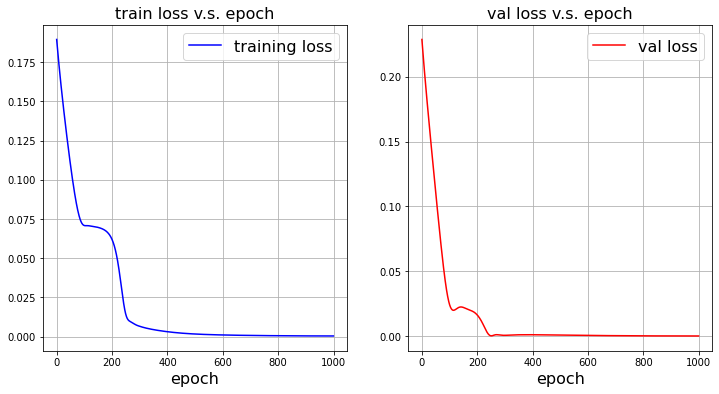

In [991]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('train loss v.s. epoch',fontsize=16)
ax[0].plot(mse_train, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)

ax[1].set_title('val loss v.s. epoch',fontsize=16)
ax[1].plot(mse_val, '-r', label='val loss')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)



In [992]:
best_epoch=np.argmin(mse_val)
best_epoch

999

In [993]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 10.128317960403457
Val RMSE Score: 7.689447171860789
Test RMSE Score: 56.656825269418114


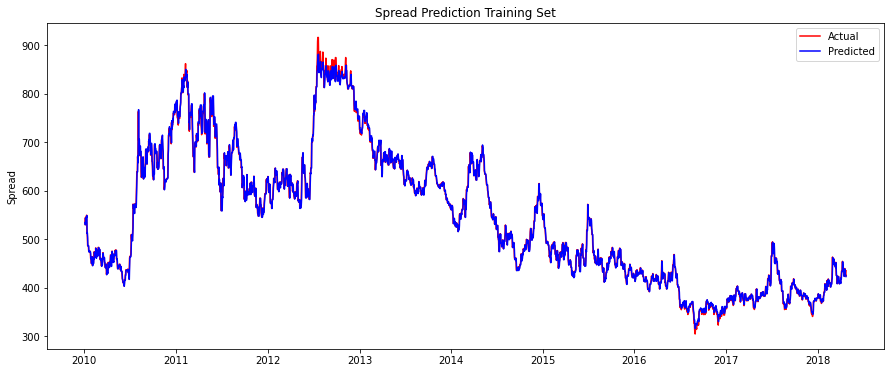

In [994]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

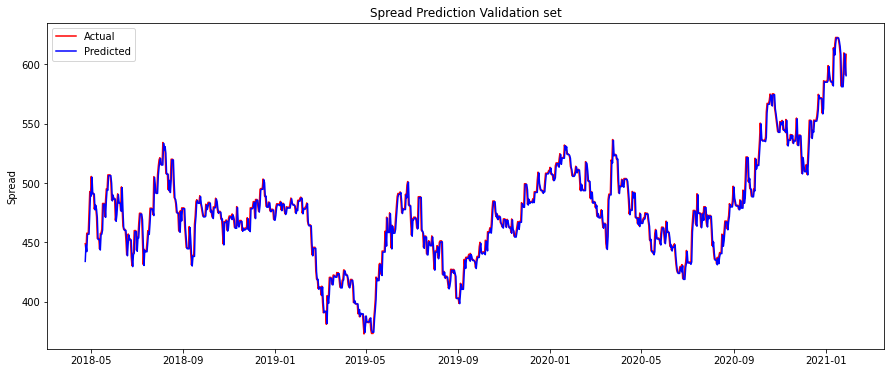

In [995]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

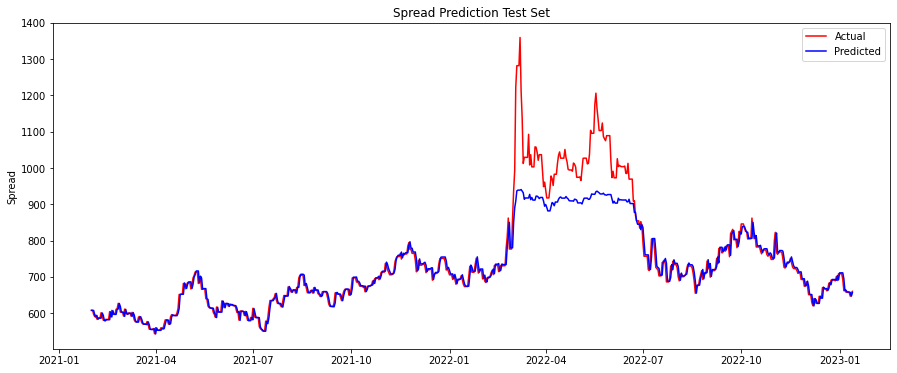

In [996]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [997]:
ydf=spread_df[0:len(y_train)].fillna(method='ffill')
y_perc_change=ydf.pct_change().fillna(method='ffill')['Adj Close']
negchange=[]
poschange=[]
for i in range(0,len(y_perc_change)):
    if y_perc_change[i]>= 0:
        poschange.append(y_perc_change[i])
    else:
        negchange.append(y_perc_change[i])

In [998]:
import math
from numpy import nan
negchange=[item for item in negchange if not(math.isnan(item)) == True]
poschange=[item for item in poschange if not(math.isnan(item)) == True]


In [999]:
pospercentile=np.percentile(poschange, np.arange(0, 100, 20))
negpercentile=np.percentile(negchange, np.arange(0, 100, 20))
top_quintile_threshold = pospercentile[-1]
bottom_quintile_threshold = negpercentile[1]

pospercentile=np.percentile(poschange, np.arange(0, 100, 10))
negpercentile=np.percentile(negchange, np.arange(0, 100, 10))
top_decile_threshold = pospercentile[-1]
bottom_decile_threshold = negpercentile[1]

In [1000]:
print('Top quintile threshold:',top_quintile_threshold,'Bottom quintile threshold:',bottom_quintile_threshold)
print('Top decile threshold:',top_decile_threshold,'Bottom decile threshold:',bottom_decile_threshold)

Top quintile threshold: 0.016202429629883146 Bottom quintile threshold: -0.023683191663159242
Top decile threshold: 0.024508205675609206 Bottom decile threshold: -0.030946515971372435


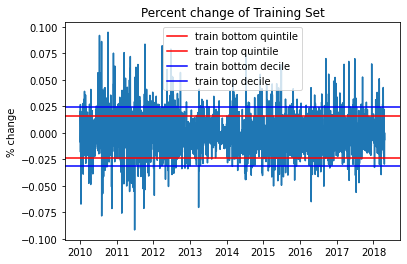

In [1001]:
plt.plot(y_perc_change)
plt.axhline(y = bottom_quintile_threshold, color = 'r', linestyle = '-',label='train bottom quintile')
plt.axhline(y = top_quintile_threshold, color = 'r', linestyle = '-',label='train top quintile')
plt.axhline(y = bottom_decile_threshold, color = 'b', linestyle = '-',label='train bottom decile')
plt.axhline(y = top_decile_threshold, color = 'b', linestyle = '-',label='train top decile')
plt.title('Percent change of Training Set')
plt.ylabel('% change')
plt.legend()
plt.show()

In [1002]:
#Percent change between forecast spread at time and actual spread 
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) 
perc_change=[]
for i in range(0,len(y_val)-2):
    
    percΔ=percentage_change(y_val[i],y_val_prediction[i+2])
    perc_change.append(percΔ)
perc_change.append(0)
    
perc=np.array(perc_change,dtype=object)

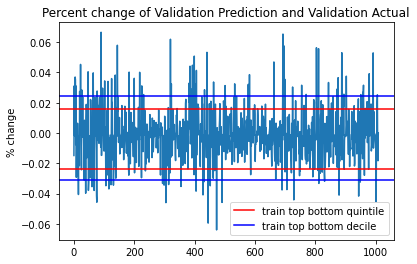

In [1005]:
plt.plot(perc)
plt.axhline(y = bottom_quintile_threshold, color = 'r', linestyle = '-',label='train top bottom quintile')
plt.axhline(y = top_quintile_threshold, color = 'r', linestyle = '-')
plt.axhline(y = bottom_decile_threshold, color = 'b', linestyle = '-',label='train top bottom decile')
plt.axhline(y = top_decile_threshold, color = 'b', linestyle = '-')
plt.title('Percent change of Validation Prediction and Validation Actual')
plt.ylabel('% change')
plt.legend()
plt.show()

# Define thresholds:
### decile and quintile method (see pairs-trading repository for in depth discussion about how to pick optimal threshold (specifically part 13: LSTM)
### calculate top and bottom decile and quintile thresholds using training set
### backtest each method on validation set whichever yields better result -> use on testing set

In [1006]:
below_quint=[]
above_quint=[]
below_dec=[]
above_dec=[]
for i in range(0,len(perc)):
    if perc[i]<= bottom_quintile_threshold:
        below_quint.append(i)
    elif perc[i] >= top_quintile_threshold:
        above_quint.append(i)
        
    if perc[i]<= bottom_decile_threshold:
        below_dec.append(i)
    elif perc[i] >= top_decile_threshold:
        above_dec.append(i)

In [1007]:
x_quint_long=[]
y_quint_long=[]
x_dec_long=[]
y_dec_long=[]

x_quint_short=[]
y_quint_short=[]
x_dec_short=[]
y_dec_short=[]

val_spread=spread_df[len(y_train):len(y_train)+len(y_val)]
for i in range(0,len(below_quint)):
    x_quint_long.append(val_spread.index[below_quint[i]])
    y_quint_long.append(val_spread['Adj Close'][below_quint[i]])

for i in range(0,len(above_quint)):
    x_quint_short.append(val_spread.index[above_quint[i]])
    y_quint_short.append(val_spread['Adj Close'][above_quint[i]])

    
for i in range(0,len(below_dec)):
    x_dec_long.append(val_spread.index[below_dec[i]])
    y_dec_long.append(val_spread['Adj Close'][below_dec[i]])

for i in range(0,len(above_dec)):
    x_dec_short.append(val_spread.index[above_dec[i]])
    y_dec_short.append(val_spread['Adj Close'][above_dec[i]])


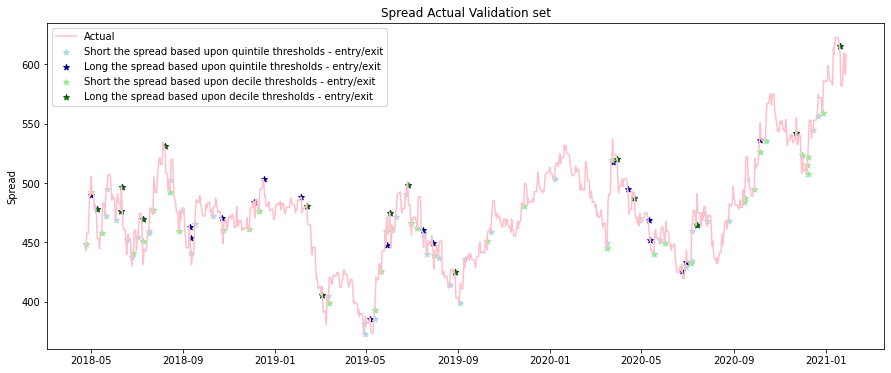

In [1008]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'pink', label = 'Actual')
plt.scatter(x_quint_short, y_quint_short, marker="*", color="lightblue",label='Short the spread based upon quintile thresholds - entry/exit')
plt.scatter(x_quint_long, y_quint_long, marker="*", color="darkblue",label='Long the spread based upon quintile thresholds - entry/exit')

plt.scatter(x_dec_short, y_dec_short, marker="*", color="lightgreen",label='Short the spread based upon decile thresholds - entry/exit')
plt.scatter(x_dec_long, y_dec_long, marker="*", color="darkgreen",label='Long the spread based upon decile thresholds - entry/exit')


plt.title('Spread Actual Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [1009]:
dates1 = pd.date_range(start_data,end_data,freq='D')
df1=pd.DataFrame(index=dates1)
A1=df1.join(Asset1)
A1=A1.fillna(method='ffill')

dates2 = pd.date_range(start_data,end_data,freq='D')
df2=pd.DataFrame(index=dates2)
A2=df2.join(Asset2)
A2=A2.fillna(method='ffill')

In [1010]:
ratio=np.abs(A1['Adj Close']/A2['Adj Close'])
val_ratio=ratio[len(y_train):len(y_train)+len(y_val)]
len(ratio)

4758

In [1011]:
x_r_quint_short=[]
y_r_quint_short=[]
x_r_quint_long=[]
y_r_quint_long=[]

x_r_dec_short=[]
y_r_dec_short=[]
x_r_dec_long=[]
y_r_dec_long=[]


for i in range(0,len(below_quint)):
    x_r_quint_long.append(val_ratio.index[below_quint[i]])
    y_r_quint_long.append(val_ratio[below_quint[i]])

for i in range(0,len(above_quint)):
    x_r_quint_short.append(val_ratio.index[above_quint[i]])
    y_r_quint_short.append(val_ratio[above_quint[i]])
    
for i in range(0,len(below_dec)):
    x_r_dec_long.append(val_ratio.index[below_dec[i]])
    y_r_dec_long.append(val_ratio[below_dec[i]])
for i in range(0,len(above_dec)):
    x_r_dec_short.append(val_ratio.index[above_dec[i]])
    y_r_dec_short.append(val_ratio[above_dec[i]])
    


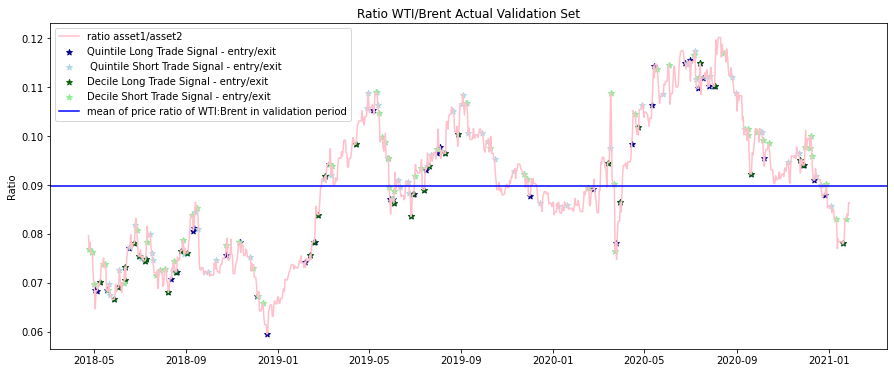

In [1012]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(val_ratio.index, val_ratio, color = 'pink', label = 'ratio asset1/asset2')


plt.scatter(x_r_quint_long, y_r_quint_long, marker="*", color="darkblue",label='Quintile Long Trade Signal - entry/exit')
plt.scatter(x_r_quint_short, y_r_quint_short, marker="*", color="lightblue",label=' Quintile Short Trade Signal - entry/exit')

plt.scatter(x_r_dec_long, y_r_dec_long, marker="*", color="darkgreen",label='Decile Long Trade Signal - entry/exit')
plt.scatter(x_r_dec_short, y_r_dec_short, marker="*", color="lightgreen",label='Decile Short Trade Signal - entry/exit')


plt.axhline(y = ratio[len(y_train):len(y_train)+len(y_val)].mean(), color = 'b', linestyle = '-',label='mean of price ratio of WTI:Brent in validation period')
plt.title('Ratio WTI/Brent Actual Validation Set')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [1013]:
#Quintile
trade=0
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
positions_quint=pd.DataFrame(index=ratio[len(y_train):len(y_train)+len(y_val)].index, columns = ['Gen Mills','CSRW','l/s spread'])
position_open=False
for date in range(0,len(perc)):  
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_quintile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'long spread']
            else:
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'long spread']
        elif perc[date]>=top_quintile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'short spread']
            else:
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'short spread']
             
        else:
            position_open = False
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [0,0,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [0,0,'no change']
    

# if position is open            
    elif position_open == True:
        if perc[date] <= bottom_quintile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'no change']
        
        elif perc[date]>= top_quintile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'no change']
        else: 
            position_open=False
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [0,0,'close trade']
            else:
                positions_quint.loc[val_ratio.index[date]] = [0,0,'close trade'] 

        

In [1014]:
#Check number of trades made (used when calculating fees/commisions)
trade_quint=trade
trade_quint

282

In [1015]:
#Decile
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
trade=0
positions=pd.DataFrame(index=ratio[len(y_train):len(y_train)+len(y_val)].index, columns = ['Gen Mills','CSRW','l/s spread'])
position_open=False
for date in range(0,len(perc)):  
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_decile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [1,-1,'long spread']
            else:
                positions.loc[val_ratio.index[date]] = [-1,1,'long spread']
        elif perc[date]>=top_decile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'short spread']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'short spread']
             
        else:
            position_open = False
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
    

# if position is open            
    elif position_open == True:
        if perc[date] <= bottom_decile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [1,-1,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [-1,1,'no change']
        
        elif perc[date]>= top_decile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'no change']
        else: 
            position_open=False
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'close trade']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'close trade'] 

        

In [1016]:
trade_dec=trade
trade_dec

172

In [1017]:


A1['log_ret'] = np.log(A1['Adj Close']) - np.log(A1['Adj Close'].shift(1))
logret_asset1=A1[len(y_train):len(y_train)+len(y_val)]
# logret_asset1_c=logret_asset1.cumsum()

A2['log_ret'] = np.log(A2['Adj Close']) - np.log(A2['Adj Close'].shift(1))
logret_asset2=A2[len(y_train):len(y_train)+len(y_val)]



p_dec=positions.join(logret_asset1)
p_quint=positions_quint.join(logret_asset1)
z_quint=p_quint.merge(logret_asset2).dropna()
z_dec=p_dec.merge(logret_asset2).dropna()

In [1018]:
algo_ret_dec = (p_dec['Gen Mills']*logret_asset1['log_ret'].shift()
                +p_dec['CSRW']*logret_asset2['log_ret'].shift())


algo_ret_quint = (p_quint['Gen Mills']*logret_asset1['log_ret'].shift()
                  +p_quint['CSRW']*logret_asset2['log_ret'].shift())


## Quintile threshold method performed better on validation set so that's what we will use going forward

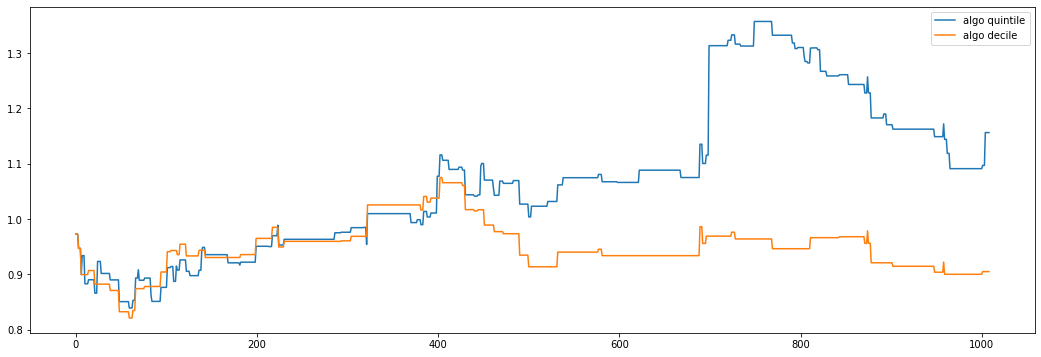

In [1019]:
algo_ret_quint=algo_ret_quint.dropna()
returns_quint=[]
for i in range(0,len(algo_ret_quint)):
    returns_quint.append(np.exp(algo_ret_quint[i])-1)
    
algo_ret_dec=algo_ret_dec.dropna()
returns_dec=[]
for i in range(0,len(algo_ret_dec)):
    returns_dec.append(np.exp(algo_ret_dec[i])-1)


plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(np.array(returns_quint)+1), label='algo quintile')
plt.plot(np.nancumprod(np.array(returns_dec)+1), label='algo decile')
plt.legend()
plt.show()

In [1020]:
def calculate_metrics(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    
    return total_return, apr, sharpe, maxDD

## Comparison of decile quintile algo

In [1021]:
metrics = pd.DataFrame(index=['Decile Algo', 'Quintile Algo'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown'])
metrics.loc['Decile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_dec)+1))
metrics.loc['Quintile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_quint)+1))

metrics

,Total return,APR,Sharpe,Max Drawdown
Decile Algo,-0.06971,-0.017885,-0.142721,-0.162864
Quintile Algo,0.188965,0.044176,0.348992,-0.196204
